# Baseline Performance Evaluation

This notebook establishes the ground truth performance of Whisper on clean LibriSpeech data 

**Goals:**
1. Load LibriSpeech `test-clean` data.
2. Initialize Whisper model.
3. Transcribe clean audio.
4. Calculate WER and CER using `jiwer`.
5. Log results for later comparison.

In [24]:
import os
import torch
import librosa
import soundfile as sf
import numpy as np
from jiwer import wer, cer
from tqdm import tqdm
import json
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt 

import warnings
import sys

import src.data as data_loader

import whisper

warnings.filterwarnings("ignore", category=UserWarning)


## 1. Setup & Configuration

In [25]:
torch.manual_seed(42)
np.random.seed(42)

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

test_clean_path = Path(data_loader.DATA_DIR) / "LibriSpeech" / "test-clean"
results_dir = Path("results")
results_dir.mkdir(exist_ok=True, parents=True)

model_name = "small"


model = whisper.load_model(model_name, device=device)
print(f"Model {model_name} loaded.")

Using device: mps
Model small loaded.


## 2. Data Loading

We load the LibriSpeech `test-clean` dataset.

In [26]:
audio_ds = data_loader.load_dataset()

Dataset not found. Attempting to download...
Checking/Downloading LibriSpeech (test-clean) to: /Users/victorhugogermano/Development/soundfinal/data


100%|██████████| 331M/331M [00:20<00:00, 16.8MB/s] 


Found 2620 audio files.
Sample: /Users/victorhugogermano/Development/soundfinal/data/LibriSpeech/test-clean/61/70970/61-70970-0040.flac


In [27]:
def get_ground_truth(audio_path: Path):
    # LibriSpeech structure: test-clean/speaker/chapter/file.flac
    # Trans file: test-clean/speaker/chapter/speaker-chapter.trans.txt
    chapter_dir = audio_path.parent
    speaker_id = audio_path.parts[-3]
    chapter_id = audio_path.parts[-2]
    trans_file = chapter_dir / f"{speaker_id}-{chapter_id}.trans.txt"
    
    if not trans_file.exists():
        return None
        
    with open(trans_file, 'r') as f:
        for line in f:
            parts = line.split()
            if parts[0] == audio_path.stem:
                return " ".join(parts[1:]).strip().lower()
    return None

## 3. Baseline Transcription Loop

Iterate through audio files, transcribe, and compute metrics.

In [32]:
results = []
base_wer = 0
base_cer = 0

audio_files = audio_ds[:50] 

for audio_str_path in tqdm(audio_files):
    audio_path = Path(audio_str_path)
    
    # Whisper expects 16kHz input
    audio_array, audio_tensor = data_loader.load_audio_tensor(str(audio_path))
    
    result = model.transcribe(
        audio_tensor.to(device), 
        language='en',
        fp16=False if device in ['cpu', 'mps'] else True
    )
    
    ground_truth = get_ground_truth(audio_path)
  
    transcribed_text = result['text'].strip().lower()
    
    current_wer = wer(ground_truth, transcribed_text)
    current_cer = cer(ground_truth, transcribed_text)
    
    rel_path = str(audio_path.relative_to(Path(data_loader.DATA_DIR)))
    
    results.append({
        'audio_path': rel_path,
        'ground_truth': ground_truth,
        'transcription': transcribed_text,
        'wer': current_wer,
        'cer': current_cer
    })
    
    base_wer += current_wer
    base_cer += current_cer

print("\n--- Baseline Results (Clean) ---")
print(f"Total Samples: {len(results)}")
print(f"Mean WER: {base_wer / len(results):.4f}")
print(f"Mean CER: {base_cer / len(results):.4f}")

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


--- Baseline Results (Clean) ---
Total Samples: 50
Mean WER: 0.2195
Mean CER: 0.0535


## Present results

Save baseline metrics for later comparison with adversarial results.

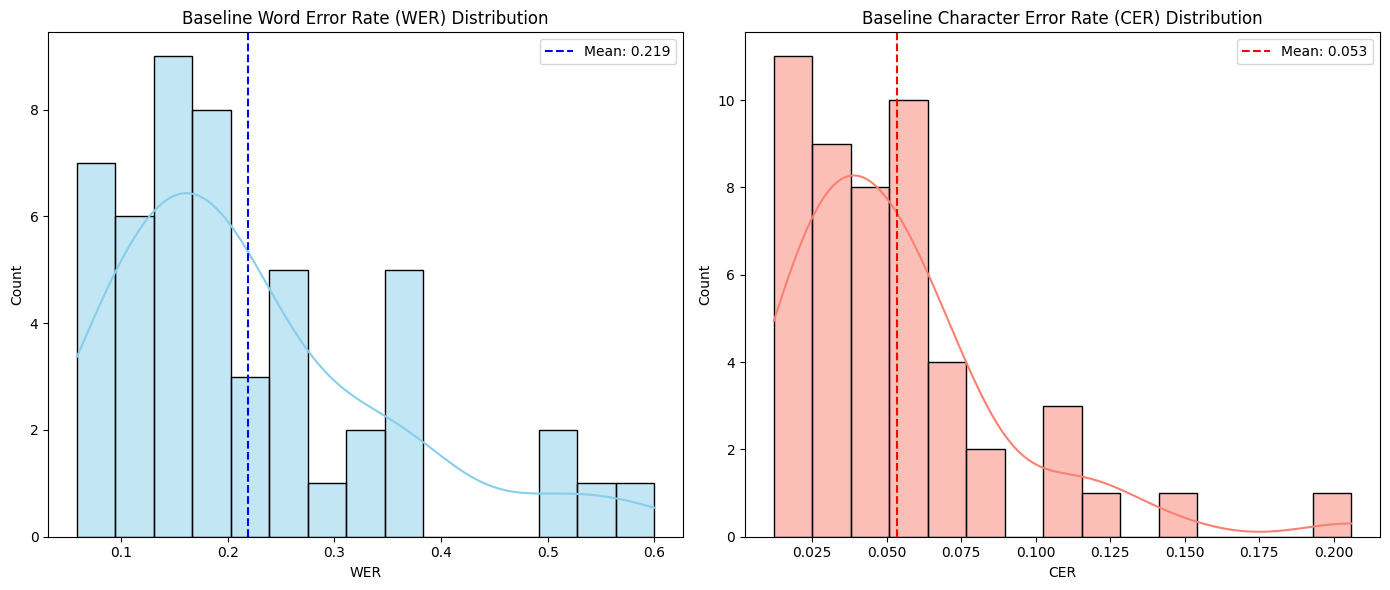

In [29]:
df_baseline = pd.DataFrame(results)

plt.figure(figsize=(14, 6))

# WER Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_baseline['wer'], bins=15, kde=True, color='skyblue')
plt.axvline(df_baseline['wer'].mean(), color='blue', linestyle='--', label=f'Mean: {df_baseline["wer"].mean():.3f}')
plt.title('Baseline Word Error Rate (WER) Distribution')
plt.xlabel('WER')
plt.legend()

# CER Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_baseline['cer'], bins=15, kde=True, color='salmon')
plt.axvline(df_baseline['cer'].mean(), color='red', linestyle='--', label=f'Mean: {df_baseline["cer"].mean():.3f}')
plt.title('Baseline Character Error Rate (CER) Distribution')
plt.xlabel('CER')
plt.legend()

plt.tight_layout()
plt.show()


,ground_truth,transcription,wer
0,they regained their apartment apparently witho...,they regain their apartment apparently without...,0.181818
1,rest and be still until i warn you,rest and be still until i warn you.,0.125000
2,there befell an anxious interview mistress fit...,"thereby fell an anxious interview, mistress fi...",0.352941
3,they then renewed their journey and under the ...,"they then renewed their journey, and under the...",0.111111
4,his tones rang pleasantly on warrenton's ears ...,his tones rang pleasantly on warrington's ears...,0.187500
5,robin fitzooth saw that his doubts of warrento...,robin fitzhuth saw that his doubts of warrento...,0.150000
6,will whispered robin opening his door as he sp...,"will, whispered robin, opening his door as he ...",0.333333
7,young fitzooth had been commanded to his mothe...,young fitz-ooth had been commanded to his moth...,0.090909
8,we will go out together to the bower there is ...,we will go out together to the bower. there is...,0.105263
9,robin carefully descended the ladder and found...,robin carefully descended the ladder and found...,0.076923


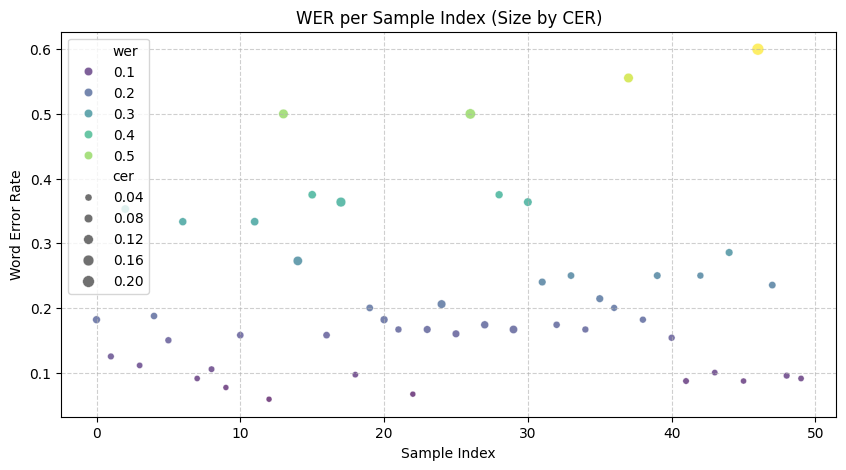

In [30]:
comparison_table = df_baseline[['ground_truth', 'transcription', 'wer']].head(10)
display(comparison_table)

# Scatter Plot: Audio Length (Estimated) vs WER
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_baseline, x=df_baseline.index, y='wer', size='cer', hue='wer', palette='viridis', alpha=0.7)
plt.title('WER per Sample Index (Size by CER)')
plt.ylabel('Word Error Rate')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [31]:
# save results and metrics for reference
with open(results_dir / 'baseline_clean_results.json', 'w') as f:
    json.dump(results, f, indent=2)

metrics = {
    'mean_wer': base_wer / len(results), 
    'mean_cer': base_cer / len(results),
    'num_samples': len(results)
}
with open(results_dir / 'baseline_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Baseline metrics saved to {results_dir.resolve()}.")

Baseline metrics saved to /Users/victorhugogermano/Development/soundfinal/results.
